In [1]:
import beamtime_config_2018
# import ROI_Finder_2018
from beamtime_config_2018 import *
# from ROI_Finder_2018 import *

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from matplotlib import rc
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path
import seaborn as sns



%matplotlib inline

In [2]:
    
class SelectFromCollection:
    """
    Select indices from a matplotlib collection using `LassoSelector`.

    Selected indices are saved in the `ind` attribute. This tool fades out the
    points that are not part of the selection (i.e., reduces their alpha
    values). If your collection has alpha < 1, this tool will permanently
    alter the alpha values.

    Note that this tool selects collection objects based on their *origins*
    (i.e., `offsets`).

    Parameters
    ----------
    ax : `~matplotlib.axes.Axes`
        Axes to interact with.
    collection : `matplotlib.collections.Collection` subclass
        Collection you want to select from.
    alpha_other : 0 <= float <= 1
        To highlight a selection, this tool sets all selected points to an
        alpha value of 1 and non-selected points to *alpha_other*.
    """

    def __init__(self, ax, collection, alpha_other=0.3):
        self.canvas = ax.figure.canvas
        self.collection = collection
        self.alpha_other = alpha_other

        self.xys = collection.get_offsets()
        self.Npts = len(self.xys)

        # Ensure that we have separate colors for each object
        self.fc = collection.get_facecolors()
        if len(self.fc) == 0:
            raise ValueError('Collection must have a facecolor')
        elif len(self.fc) == 1:
            self.fc = np.tile(self.fc, (self.Npts, 1))

        self.lasso = LassoSelector(ax, onselect=self.onselect)
        self.ind = []

    def onselect(self, verts):
        path = Path(verts)
        self.ind = np.nonzero(path.contains_points(self.xys))[0]
        self.fc[:, -1] = self.alpha_other
        self.fc[self.ind, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()

    def disconnect(self):
        self.lasso.disconnect_events()
        self.fc[:, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()
        
def accept(event):
    if event.key == "enter":
        print("Selected points:")
        print(selector.xys[selector.ind])
        selector.disconnect()
        ax.set_title("")
        fig.canvas.draw()

In [3]:
def calc_SNR(img, seg_img, labels = (0,1), mask_ratio = None):
    """
    SNR =  1     /  s*sqrt(std0^^2 + std1^^2)  
    where s = 1 / (mu1 - mu0)  
    mu1, std1 and mu0, std0 are the mean / std values for each of the segmented regions respectively (pix value = 1) and (pix value = 0).  
    seg_img is used as mask to determine stats in each region.  
    Parameters
    ----------
    img : np.array  
        raw input image (2D or 3D)  

    seg_img : np.array  
        segmentation map (2D or 3D)  

    labels : tuple  
        an ordered list of two label values in the image. The high value is interpreted as the signal and low value is the background.  

    mask_ratio : float or None
        If not None, a float in (0,1). The data are cropped such that the voxels / pixels outside the circular mask are ignored.  
    Returns
    -------
    float
        SNR of img w.r.t seg_img  
    """
    eps = 1.0e-12
    # handle circular mask  
    if mask_ratio is not None:
        crop_val = int(img.shape[-1]*0.5*(1 - mask_ratio/np.sqrt(2)))
        crop_slice = slice(crop_val, -crop_val)    

        if img.ndim == 2: # 2D image
            img = img[crop_slice, crop_slice]
            seg_img = seg_img[crop_slice, crop_slice]
        elif img.ndim == 3: # 3D image
            vcrop = int(img.shape[0]*(1-mask_ratio))
            vcrop_slice = slice(vcrop, -vcrop)
            img = img[vcrop_slice, crop_slice, crop_slice]
            seg_img = seg_img[vcrop_slice, crop_slice, crop_slice]

    pix_1 = img[seg_img == labels[1]]
    pix_0 = img[seg_img == labels[0]]

    if np.any(pix_1) and np.any(pix_0):
        mu1 = np.mean(pix_1)
        mu0 = np.mean(pix_0)
        s = abs(1/(mu1 - mu0 + eps))
        std1 = np.std(pix_1)
        std0 = np.std(pix_0)
        std = np.sqrt(0.5*(std1**2 + std0**2))
        std = s*std
        return 1/(std + eps)
    else:
        return 1/(np.std(img) + eps)

In [4]:
class beamtime_XRF_image:
    
    def __init__(self, xrf_filename = '/data01/AZC/XRF_Data/bnp_fly0001_2018_1.h5',
             BASE_PATCH_WIDTH=32, verbosity=False):
        self.xrf_filename =xrf_filename
        self.BASE_PATCH_WIDTH=BASE_PATCH_WIDTH
        
        
        
    def load_xrf_data(self, hdf5_string = 'MAPS'):
#         global d_Cu, d_Zn, d_Ca, d_K, d_P, d_S,d_Fe, d_Ni, d_TFY
    
#         norm_ch = NORM_CH # 2018 value
        norm_ch = 'US_IC'
        value_offset=VALUE_OFFSET
        xrfdata = collections.defaultdict(list)

        with h5py.File(self.xrf_filename, 'r') as dat:
            groups= list(dat.keys())
#             print('groups', groups)
            maps= list(dat['MAPS'].keys())
#             print('maps', maps)
            chs = dat['MAPS/channel_names'][:].astype(str).tolist()
        #         dat['MAPS/']
            
            print('chs:', chs)
            
            self.int_spec=dat['MAPS/int_spec'][:].astype(int).tolist()
            self.energy=dat['MAPS/energy'][:].astype(int).tolist()
            
            self.mca_arr=dat['MAPS/mca_arr'][:].astype(int).tolist()
            self.scan_time_stamp=dat['MAPS/scan_time_stamp']
#             print(self.scan_time_stamp)
            xrf = dat['MAPS/XRF_roi'][:]
        #         print(xrf)

            scaler_names = dat['MAPS/scaler_names'][:].astype(str).tolist()
            print('scaler_names:', scaler_names)
            scaler_val = dat['MAPS/scalers'][:]
#             print(scaler_val)
            norm = scaler_val[scaler_names.index(norm_ch)]
#             print('norm:', norm)
            for e in chs:
                chidx = chs.index(e)
                xrfdata[e].append(xrf[chidx]/norm)
            xrfdata['scan_num'].append(self.xrf_filename)

            hdf5_string = hdf5_string

            xrfdata['x_axis'].append(dat[hdf5_string + '/x_axis'][:])
            xrfdata['y_axis'].append(dat[hdf5_string + '/y_axis'][:])

        #         xrfdata['x_axis'].append(dat['exchange_4/x_axis'][:])
        #         xrfdata['y_axis'].append(dat['exchange_4/y_axis'][:])
        xrfdata = pd.DataFrame(xrfdata)
        #     print(xrfdata)

#         elms=['Cu','Zn','Ca', 'K', 'P', 'S','Fe','Total_Fluorescence_Yield']#Default elms
        elms=['Cu','Zn','Ca', 'K', 'P', 'S','Fe','Cl','Total_Fluorescence_Yield']#Default elms
        for i, row in xrfdata.iterrows():
                sc = row['scan_num'][0:row['scan_num'].index('.')]
                for e in elms:
                    d = row[e]

                    d[np.isnan(d) | np.isinf(d)] = 0
                    norm_d = (d - np.min(d)) / (np.max(d) - np.min(d)) + value_offset
                    ss = np.round(np.abs(np.diff(row['x_axis']))[0], 2)
                    if e == 'Cu':
                        self.d_Cu=d
                        self.norm_d_Cu=norm_d
                        self.x_Cu,self.y_Cu=row['x_axis'], row['y_axis']
                    if e == 'Zn':
                        self.d_Zn=d
                        self.norm_d_Zn=norm_d
                        self.x_Zn,self.y_Zn=row['x_axis'], row['y_axis']
                    if e == 'Ca':
                        self.d_Ca=d
                        self.norm_d_Ca=norm_d
                        self.x_Ca,self.y_Ca=row['x_axis'], row['y_axis']
                    if e == 'K':
                        self.d_K=d
                        self.norm_d_K=norm_d
                        self.x_K,self.y_K=row['x_axis'], row['y_axis']
                    if e == 'P':
                        self.d_P=d
                        self.norm_d_P=norm_d
                        self.x_P,self.y_P=row['x_axis'], row['y_axis']
                    if e == 'S':
                        self.d_S=d
                        self.norm_d_S=norm_d
                        self.x_S,self.y_S=row['x_axis'], row['y_axis']

                    if e == 'Fe':
                        self.d_Fe=d
                        self.norm_d_Fe=norm_d
                        self.x_Fe,self.y_Fe=row['x_axis'], row['y_axis']

                    if e == 'Cl':
                        
                        self.d_Ni=d
                        self.norm_d_Ni=norm_d
                        self.x_Ni,self.y_Ni=row['x_axis'], row['y_axis']

                    if e == 'Total_Fluorescence_Yield':
                        self.d_TFY=d
                        self.norm_d_TFY=norm_d
                        self.x_TFY,self.y_TFY=row['x_axis'], row['y_axis']
#             print('Image shape: ',d.shape)
            
        
        #motor coordinate, steps, resolution
        
        self.x_res=self.x_TFY[1]-self.x_TFY[0]
        self.y_res=self.y_TFY[1]-self.y_TFY[0]
        self.avg_res=(self.x_res+self.y_res)/2
        self.x_origin=self.x_TFY[0]
        self.y_origin=self.y_TFY[0]
        
        
        #debug info
        print('x_res:',self.x_res)
        print('y_res:',self.y_res)
        print('avg_res:',self.avg_res)
        
        print('x_origin:',self.x_origin)
        print('y_origin:',self.y_origin)
        
                    
    def add_noise(self, noise='none'):
        self.noise=noise
        if self.noise == 'normal':
            np.random.seed(0)
            self.normal_noise=abs(np.random.normal(0, 1, self.d_Cu.shape))
            self.d_Cu = self.d_Cu*(1+self.normal_noise) 
            self.d_Zn = self.d_Zn*(1+self.normal_noise)
            self.d_Ca = self.d_Ca*(1+self.normal_noise)
            self.d_K = self.d_K*(1+self.normal_noise)
            self.d_P = self.d_P*(1+self.normal_noise)
            self.d_S = self.d_S*(1+self.normal_noise)
            self.d_Fe = self.d_Fe*(1+self.normal_noise)
            self.d_Ni = self.d_Ni*(1+self.normal_noise)
            self.d_TFY = self.d_TFY*(1+self.normal_noise)
            
        elif self.noise == 'poisson':
            np.random.seed(0)
            self.poisson_noise=abs(np.random.poisson(1000, self.d_Cu.shape))
            self.d_Cu = self.d_Cu*(1+self.poisson_noise) 
            self.d_Zn = self.d_Zn*(1+self.poisson_noise)
            self.d_Ca = self.d_Ca*(1+self.poisson_noise)
            self.d_K = self.d_K*(1+self.poisson_noise)
            self.d_P = self.d_P*(1+self.poisson_noise)
            self.d_S = self.d_S*(1+self.poisson_noise)
            self.d_Fe = self.d_Fe*(1+self.poisson_noise)
            self.d_Ni = self.d_Ni*(1+self.poisson_noise)
            self.d_TFY = self.d_TFY*(1+self.poisson_noise)


        
    
    
    def binary_conversion(self, e='Cu'):
        #choose elemental channel for conversion
        
        if e == 'Cu':
            data_original = self.d_Cu
            
        if e == 'Zn':
            data_original = self.d_Zn
            
        if e == 'Ca':
            data_original = self.d_Ca
            
        if e == 'K':
            data_original = self.d_K
            
        if e == 'P':
            data_original = self.d_P
            
        if e == 'S':
            data_original = self.d_S
            

        if e == 'Fe':
            data_original = self.d_Fe
            

        if e == 'Cl':
            data_original = self.d_Ni
            
        if e == 'Total_Fluorescence_Yield':
            data_original = self.d_TFY
            
#         data_original=d_Cu
        data=data_original
        data = ndimage.median_filter(data, size=3)


        thresh = 1.25*threshold_otsu(data)
        binary = data < thresh
        binary = binary^1


        binary_eroded=ndimage.binary_erosion(binary).astype(binary.dtype)
        binary_dilated=ndimage.binary_dilation(binary).astype(binary.dtype)
        self.binary_ero_dil=ndimage.binary_dilation(binary_eroded).astype(binary_eroded.dtype)
        
        self.labeled_array, self.num_features = label(self.binary_ero_dil)
        
    def extract_cells(self):
        self.regions = measure.regionprops(self.labeled_array)    
        # print(len(regions))

        self.cell_list = []
        self.center_list = []
        self.Patches_Cu = []
        self.Patches_Zn = []
        self.Patches_Ca = []
        self.Patches_K = []
        self.Patches_P = []
        self.Patches_S = []
        self.Patches_Fe = []
        self.Patches_Ni = []
        self.Patches_TFY= []
        self.binary_img=[]
        self.region_vals=[]
        self.features_list = []
        self.center_coords=[]
        self.XRF_track_files=[]
        
        #motor coordinate stuff
        
        self.x_res_list= []
        self.y_res_list= []
        self.avg_res_list= []
        self.x_origin_list= []
        self.y_origin_list= []
        
        self.x_motor_center_list= []
        self.y_motor_center_list= []


        for idx in range(len(self.regions)):
            
            #append motor coordinate stuff for each region so they can be retrived later via pandas
            
            self.x_res_list.append(self.x_res)
            self.y_res_list.append(self.y_res) 
            self.avg_res_list.append(self.avg_res)
            self.x_origin_list.append(self.x_origin)
            self.y_origin_list.append(self.y_origin)
            
            #cell extraction begins here
            
            self.cell_val_bin=self.regions[idx].image
            
            self.center_coords.append(self.regions[idx].centroid)
            self.XRF_track_files.append(self.xrf_filename)

            self.region_vals.append(self.cell_val_bin)
            self.padded_cell = np.pad(self.cell_val_bin, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.cell_list.append(self.padded_cell)
            self.center_list.append([math.floor(self.regions[idx].centroid[0]), math.floor(self.regions[idx].centroid[1])])
            #center list is given in (y,x)
            #calculate motor centers here
            
            self.x_motor_center_list.append(self.x_origin_list[idx] + self.x_res_list[idx]*self.center_list[idx][1])
            self.y_motor_center_list.append(self.y_origin_list[idx] + self.y_res_list[idx]*self.center_list[idx][0])
            
            
        #     regions[idx].bbox

            self.cell_Cu = self.d_Cu[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Zn = self.d_Zn[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Ca = self.d_Ca[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_K = self.d_K[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_P = self.d_P[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_S = self.d_S[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Fe = self.d_Fe[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_Ni = self.d_Ni[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]
            self.cell_TFY = self.d_TFY[self.regions[idx].bbox[0]:self.regions[idx].bbox[2],self.regions[idx].bbox[1]:self.regions[idx].bbox[3]]

            self.padded_bin = np.pad(self.cell_val_bin, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Cu = np.pad(self.cell_Cu, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Zn = np.pad(self.cell_Cu, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Ca = np.pad(self.cell_Cu, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_K = np.pad(self.cell_K, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_P = np.pad(self.cell_P, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_S = np.pad(self.cell_S, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Fe = np.pad(self.cell_Fe, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_Ni = np.pad(self.cell_Ni, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))
            self.padded_TFY = np.pad(self.cell_TFY, ((math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[0])/2)),(math.floor((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2),math.ceil((self.BASE_PATCH_WIDTH-self.cell_val_bin.shape[1])/2))), mode='constant', constant_values=(0))

            self.binary_img.append(self.padded_bin)
            self.Patches_Cu.append(self.padded_Cu)
            self.Patches_Zn.append(self.padded_Zn)
            self.Patches_Ca.append(self.padded_Ca)
            self.Patches_K.append(self.padded_K)
            self.Patches_P.append(self.padded_P)
            self.Patches_S.append(self.padded_S)
            self.Patches_Fe.append(self.padded_Fe)
            self.Patches_Ni.append(self.padded_Ni)
            self.Patches_TFY.append(self.padded_TFY)


            # define feature vector using averages
        #     x = np.asarray([regions[idx].area, 
        #      regions[idx].eccentricity, 
        #      regions[idx].equivalent_diameter, 
        #      regions[idx].major_axis_length,
        #      regions[idx].minor_axis_length,
        #      regions[idx].perimeter,
        #      np.average(Patches_K[idx]),
        #      np.average(Patches_K[idx])/np.average(Patches_P[idx]),
        #      np.average(Patches_Ni[idx]),
        #      np.average(Patches_Ni[idx])/np.average(Patches_P[idx]),
        #     np.average(Patches_Ni[idx])/np.average(Patches_K[idx]),
        #     np.average(Patches_Cu[idx])/np.average(Patches_K[idx]),
        #     ])

            # define feature vector using averages
            self.avg_res
            
            self.x = np.asarray([self.avg_res*self.avg_res*self.regions[idx].area, 
             self.regions[idx].eccentricity, 
             self.avg_res*self.regions[idx].equivalent_diameter, 
             self.avg_res*self.regions[idx].major_axis_length,
             self.avg_res*self.regions[idx].minor_axis_length,
             self.avg_res*self.regions[idx].perimeter,
             np.amax(self.Patches_K[idx]),
             np.amax(self.Patches_P[idx]),
             np.amax(self.Patches_Ni[idx]),
             np.amax(self.Patches_Zn[idx]),
            np.amax(self.Patches_Fe[idx]),
            np.amax(self.Patches_Cu[idx]),
            np.amax(self.Patches_TFY[idx]-self.Patches_K[idx]-self.Patches_P[idx]-self.Patches_Ni[idx]-self.Patches_Zn[idx]-self.Patches_Fe[idx]-self.Patches_Cu[idx]),
            np.unique(x.region_vals[idx], return_counts=True)[1][1] # returns the number of true (1's) values in the identified region
            ])

            self.features_list.append(self.x)
        self.features=np.asarray(self.features_list)



In [5]:
current_xrf_filename = '/home/beams/USERBNP/arshad/Practice_h5/bnp_fly0032.mda.h5'

x= beamtime_XRF_image(xrf_filename = current_xrf_filename,
             BASE_PATCH_WIDTH=32, verbosity=False)
x.load_xrf_data(hdf5_string='MAPS')
# x.add_noise(noise=noise_type)

x.binary_conversion(e='P')
x.extract_cells()
X_bin1=x.binary_img  


X_Cu1=x.Patches_Cu
X_Zn1=x.Patches_Zn
X_Ca1=x.Patches_Ca
X_K1=x.Patches_K
X_P1=x.Patches_P
X_S1=x.Patches_S
X_Fe1=x.Patches_Fe
X_Ni1=x.Patches_Ni
X_TFY1=x.Patches_TFY

X_x_res1=x.x_res_list
X_y_res1=x.y_res_list
X_avg_res1=x.avg_res_list
X_x_origin1=x.x_origin_list
X_y_origin1=x.y_origin_list

X_x_motor1=x.x_motor_center_list
X_y_motor1=x.y_motor_center_list


SNR_X1=calc_SNR(x.d_Zn, x.binary_ero_dil)

X1=x.features

X_centers1=x.center_coords
X_xrf_track_file1=x.XRF_track_files

X1.shape

chs: ['Si', 'P', 'S', 'Cl', 'K', 'Ca', 'Ti', 'Cr', 'Fe', 'Cu', 'Zn', 'Ag_L', 'Si_Cl', 'Num_Iter', 'Total_Fluorescence_Yield', 'Si_Si', 'Cl_Cl', 'COHERENT_SCT_AMPLITUDE', 'COMPTON_AMPLITUDE', 'Fit_Residual', 'Sum_Elastic_Inelastic']
scaler_names: ['CFG_2', 'CFG_3', 'CFG_4', 'CFG_5', 'DS_IC', 'Dead_Time', 'ELT', 'ERT', 'H_dpc_cfg', 'ICR1', 'ICR2', 'ICR3', 'ICR4', 'INCNT', 'OCR1', 'OCR2', 'OCR3', 'OCR4', 'OUTCNT', 'US_IC', 'V_dpc_cfg', 'abs_cfg', 'abs_ic', 'dia1_dpc_cfg', 'dia2_dpc_cfg']
x_res: 0.25
y_res: 0.25628662
avg_res: 0.253143310546875
x_origin: 110.67438
y_origin: -661.0652


(32, 14)

In [6]:
x.center_coords
# x.center_list

[(26.258064516129032, 258.35483870967744),
 (36.3448275862069, 42.89655172413793),
 (40.0, 114.0),
 (52.28947368421053, 272.8157894736842),
 (54.73684210526316, 167.81578947368422),
 (65.36170212765957, 98.85106382978724),
 (66.29032258064517, 129.29032258064515),
 (68.2, 250.42),
 (71.5, 11.181818181818182),
 (73.8082191780822, 50.04109589041096),
 (75.0, 169.5),
 (77.0, 5.5),
 (76.0, 164.0),
 (83.0, 94.88888888888889),
 (90.96, 32.2),
 (90.0, 94.0),
 (98.5, 230.0),
 (103.0, 134.0),
 (104.5, 232.0),
 (142.26, 169.7),
 (142.46153846153845, 186.2991452991453),
 (149.5, 178.0),
 (171.43333333333334, 68.96666666666667),
 (176.32432432432432, 179.94594594594594),
 (192.82857142857142, 127.42857142857143),
 (216.5, 61.5),
 (216.5, 6.5),
 (225.78571428571428, 281.3392857142857),
 (255.94871794871796, 154.46153846153845),
 (264.20952380952383, 188.17142857142858),
 (254.5, 233.5),
 (265.0, 43.0)]

(271, 321)


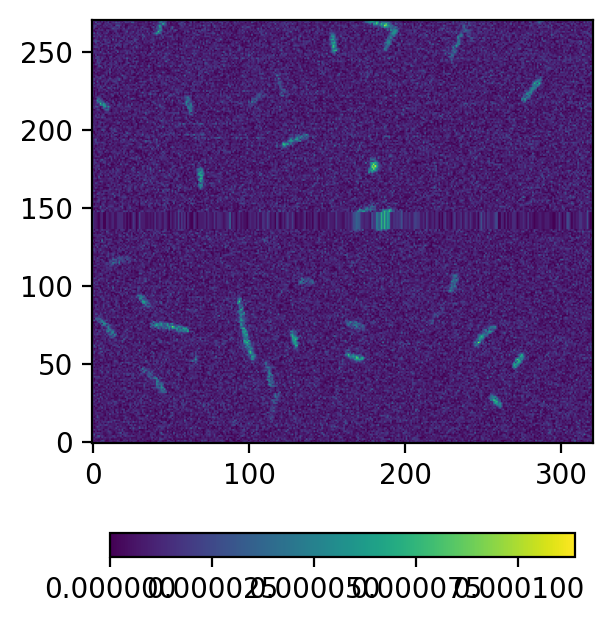

In [7]:
print(x.d_K.shape)
plt.figure(dpi=200)
plt.imshow(x.d_P)
plt.colorbar(orientation='horizontal', shrink=0.5)
plt.gca().invert_yaxis()

(271, 321)


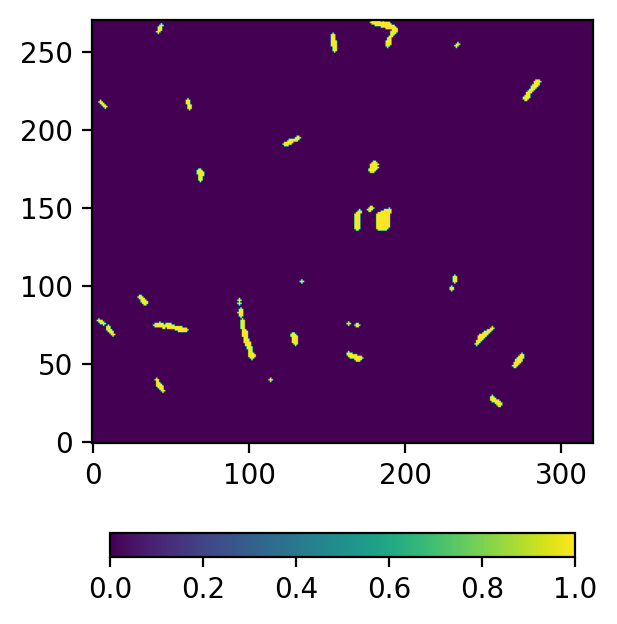

In [8]:
print(x.d_K.shape)
plt.figure(dpi=200)
plt.imshow(x.binary_ero_dil)
plt.colorbar(orientation='horizontal', shrink=0.5)
plt.gca().invert_yaxis()

(271, 321)


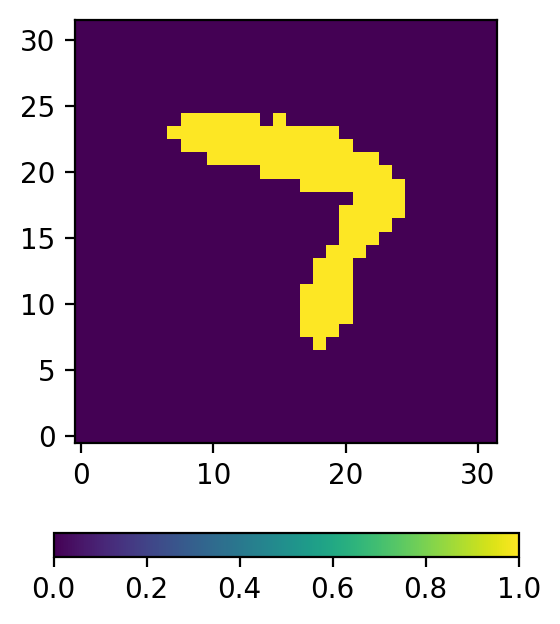

In [9]:
print(x.d_K.shape)
plt.figure(dpi=200)
plt.imshow(x.binary_img[29])
plt.colorbar(orientation='horizontal', shrink=0.5)
plt.gca().invert_yaxis()

In [10]:
X=X1

X_bin=np.asarray(X_bin1)


X_Cu = np.asarray(X_Cu1)
X_Zn = np.asarray(X_Zn1)
X_Ca = np.asarray(X_Ca1)
X_K = np.asarray(X_K1)
X_P = np.asarray(X_P1)
X_S = np.asarray(X_S1)
X_Fe = np.asarray(X_Fe1)
X_Ni = np.asarray(X_Ni1)
X_TFY = np.asarray(X_TFY1)

X_x_res = np.asarray(X_x_res1)
X_y_res = np.asarray(X_y_res1)
X_avg_res = np.asarray(X_avg_res1)
X_x_origin = np.asarray(X_x_origin1)
X_y_origin = np.asarray(X_y_origin1)



X_centers = np.asarray(X_centers1)
X_x_motor = np.asarray(X_x_motor1)
X_y_motor = np.asarray(X_y_motor1)
X_xrf_track_files=np.asarray(X_xrf_track_file1)


print('Total extracted cells, features:', X.shape)
print('Total extracted cell, cell size:', X_bin.shape)


Total extracted cells, features: (32, 14)
Total extracted cell, cell size: (32, 32, 32)


In [11]:
BASE_PATCH_WIDTH=x.BASE_PATCH_WIDTH
principalDf = pd.DataFrame(
             columns = ['Pixel_count', 'area'])

principalDf['area'] = X[:,0]
principalDf['eccentricity'] = X[:,1]
principalDf['equivalent_diameter'] = X[:,2]
principalDf['major_axis_length'] = X[:,3]
principalDf['minor_axis_length'] = X[:,4]
principalDf['perimeter'] = X[:,5]
principalDf['K'] = X[:,6]
principalDf['P'] = X[:,7]
principalDf['Ni'] = X[:,8]
principalDf['Zn'] = X[:,9]
principalDf['Fe'] = X[:,10]
principalDf['Cu'] = X[:,11]
principalDf['BFY'] = X[:,12]
principalDf['Pixel_count'] = X[:,13].astype(int)
display(principalDf)


#add res and origins to dataframe here

principalDf['x_res'] = X_x_res
principalDf['y_res'] = X_y_res
principalDf['avg_res'] = X_avg_res
principalDf['x_origin'] = X_x_origin
principalDf['y_origin'] = X_y_origin
principalDf['x_motor'] = X_x_motor
principalDf['y_motor'] = X_y_motor


,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ni,Zn,Fe,Cu,BFY
0,31,1.986528,0.926912,1.590385,2.643454,0.992034,5.456846,0.000042,0.000084,0.000102,0.000076,0.000038,0.000076,0.007248
1,29,1.858365,0.945945,1.538227,2.743256,0.889710,5.351990,0.000064,0.000055,0.000096,0.000046,0.000044,0.000046,0.007148
2,5,0.320408,0.000000,0.638714,0.640408,0.640408,1.431995,0.000042,0.000050,0.000076,0.000038,0.000036,0.000038,0.007151
3,38,2.435098,0.932115,1.760813,2.920293,1.057619,6.172843,0.000050,0.000083,0.000103,0.000057,0.000046,0.000057,0.007343
4,38,2.435098,0.933353,1.760813,3.025941,1.086188,6.469419,0.000044,0.000085,0.000089,0.000042,0.000043,0.000042,0.007300
5,94,6.023664,0.989542,2.769398,7.592960,1.095271,15.050849,0.000060,0.000079,0.000101,0.000048,0.000051,0.000048,0.007345
6,31,1.986528,0.877474,1.590385,2.300224,1.103244,5.037424,0.000050,0.000077,0.000096,0.000046,0.000046,0.000046,0.007193
7,50,3.204077,0.971656,2.019791,4.318267,1.020839,7.604838,0.000049,0.000099,0.000133,0.000053,0.000039,0.000053,0.007266
8,22,1.409794,0.930473,1.339778,2.246039,0.822862,4.234562,0.000042,0.000054,0.000083,0.000047,0.000047,0.000047,0.007231
9,73,4.677952,0.986584,2.440523,6.305439,1.029406,12.099995,0.000079,0.000094,0.000095,0.000063,0.000047,0.000063,0.007273


In [12]:
# get the annotated data so remove if not annotated
# secondaryDf=principalDf[principalDf['KO_label'] != 'not_annotated' ]
secondaryDf=principalDf

# remove additional artifacts that do not contain 8 pixels, currently set to 3
secondaryDf=secondaryDf[secondaryDf['Pixel_count'] >8]

#keep track of the original indices after removing artifacts
secondaryDf['original index'] = secondaryDf.index.to_numpy()
secondaryDf.reset_index(drop=True, inplace=True)

print('Bounding box width and height (pixels):' , BASE_PATCH_WIDTH)
 

Bounding box width and height (pixels): 32


/APSshare/anaconda3/x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [13]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(secondaryDf)

# secondaryDf.head()

,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ni,Zn,Fe,Cu,BFY,x_res,y_res,avg_res,x_origin,y_origin,x_motor,y_motor,original index
0,31,1.986528,0.926912,1.590385,2.643454,0.992034,5.456846,0.000042,0.000084,0.000102,0.000076,0.000038,0.000076,0.007248,0.25,0.256287,0.253143,110.674377,-661.065186,175.174377,-654.401733,0
1,29,1.858365,0.945945,1.538227,2.743256,0.889710,5.351990,0.000064,0.000055,0.000096,0.000046,0.000044,0.000046,0.007148,0.25,0.256287,0.253143,110.674377,-661.065186,121.174377,-651.838867,1
2,38,2.435098,0.932115,1.760813,2.920293,1.057619,6.172843,0.000050,0.000083,0.000103,0.000057,0.000046,0.000057,0.007343,0.25,0.256287,0.253143,110.674377,-661.065186,178.674377,-647.738281,3
3,38,2.435098,0.933353,1.760813,3.025941,1.086188,6.469419,0.000044,0.000085,0.000089,0.000042,0.000043,0.000042,0.007300,0.25,0.256287,0.253143,110.674377,-661.065186,152.424377,-647.225708,4
4,94,6.023664,0.989542,2.769398,7.592960,1.095271,15.050849,0.000060,0.000079,0.000101,0.000048,0.000051,0.000048,0.007345,0.25,0.256287,0.253143,110.674377,-661.065186,135.174377,-644.406555,5
5,31,1.986528,0.877474,1.590385,2.300224,1.103244,5.037424,0.000050,0.000077,0.000096,0.000046,0.000046,0.000046,0.007193,0.25,0.256287,0.253143,110.674377,-661.065186,142.924377,-644.150269,6
6,50,3.204077,0.971656,2.019791,4.318267,1.020839,7.604838,0.000049,0.000099,0.000133,0.000053,0.000039,0.000053,0.007266,0.25,0.256287,0.253143,110.674377,-661.065186,173.174377,-643.637695,7
7,22,1.409794,0.930473,1.339778,2.246039,0.822862,4.234562,0.000042,0.000054,0.000083,0.000047,0.000047,0.000047,0.007231,0.25,0.256287,0.253143,110.674377,-661.065186,113.424377,-642.868835,8
8,73,4.677952,0.986584,2.440523,6.305439,1.029406,12.099995,0.000079,0.000094,0.000095,0.000063,0.000047,0.000063,0.007273,0.25,0.256287,0.253143,110.674377,-661.065186,123.174377,-642.356262,9
9,14,0.897141,0.905899,1.068773,1.643562,0.696039,2.654279,0.000052,0.000060,0.000086,0.000046,0.000042,0.000046,0.007269,0.25,0.256287,0.253143,110.674377,-661.065186,111.924377,-641.331116,11


In [14]:
selected_elm_channel = 'P'
# selected_elm_channel =  'Total_Fluorescence_Yield'

%matplotlib inline

def viewer(idx):
    
#     x = beamtime_XRF_image(xrf_filename = X_xrf_track_files[idx],
#              BASE_PATCH_WIDTH=32, verbosity=False)
    
    x = beamtime_XRF_image(xrf_filename = X_xrf_track_files[idx],
             BASE_PATCH_WIDTH=32, verbosity=False)

    x.load_xrf_data(hdf5_string='MAPS')
    
    
    if selected_elm_channel == 'Cu':
        d_XRF=x.d_Cu

    if selected_elm_channel == 'Zn':
        d_XRF=x.d_Zn

    if selected_elm_channel == 'Ca':
        d_XRF=x.d_Ca

    if selected_elm_channel == 'K':
        d_XRF=x.d_K

    if selected_elm_channel == 'P':
        d_XRF=x.d_P

    if selected_elm_channel == 'S':
        d_XRF=x.d_S

    if selected_elm_channel == 'Fe':
        d_XRF=x.d_Fe

    if selected_elm_channel == 'Ni':
        d_XRF=x.d_Ni

    if selected_elm_channel == 'Total_Fluorescence_Yield':
        d_XRF=x.d_TFY

    
    
    fig, ax = plt.subplots(dpi=150)
    
    img=ax.imshow(d_XRF)
    ax.set_title('Selected Channel: ' + selected_elm_channel)
    ax.invert_yaxis()
    fig.colorbar(img, orientation='vertical')
    
    #16 is the halfwidth of the images
    # we get centers from the patches2d data structure, but the bounding box requires corner points
    
    cell_bbox = patches.Rectangle((X_centers[idx][1]-16, X_centers[idx][0]-16), 32, 32, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(cell_bbox)


    # OR PLOT cross-hair to mark location in main image
#     ax.plot(X_centers[idx][1], X_centers[idx][0], 'w+', markersize=CROSS_HAIR_SIZE)
    
    print('x_motor:',X_x_motor[idx])
    print('y_motor:',X_y_motor[idx])
    print('x_center:',X_centers[idx][0])
    print('y_center:',X_centers[idx][1])
    
    
    fig = plt.figure(figsize=(10, 20))
    fig.suptitle('cell_img'+ '_' + str(idx))

    ax1 = fig.add_subplot(521)
    ax1.set_title('binary'+ '_' + str(idx))
    
    im1 = ax1.imshow(X_bin[idx], interpolation='none')
    
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
#     scalebar_master = ScaleBar( SCALE_UNIT_FACTOR*resolution, "m", color='white', length_fraction=0.10, box_alpha=0.10)
#     ax1.add_artist(scalebar_master)
    ax1.invert_yaxis()
    

    
    

interactive_plot = interactive(viewer, idx=(0, len(X_bin)-1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=15, description='idx', max=31), Output()), _dom_classes=('widget-interac…

In [15]:
linethresh_val=0.00001
resolution=DEFAULT_RESOLUTION_CELL

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors


In [16]:
linethresh_val=0.00001
resolution=DEFAULT_RESOLUTION_CELL

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
%matplotlib inline


def viewer(idx):

    fig = plt.figure(figsize=(10, 20))
    fig.suptitle('cell_img'+ '_' + str(idx))

    ax1 = fig.add_subplot(521)
    ax1.set_title('binary'+ '_' + str(idx))
    
    im1 = ax1.imshow(X_bin[idx], interpolation='none')
    
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')
    scalebar_master = ScaleBar( SCALE_UNIT_FACTOR*resolution, "m", color='white', length_fraction=0.10, box_alpha=0.10)
    ax1.add_artist(scalebar_master)
    ax1.invert_yaxis()
    
    

    ax2 = fig.add_subplot(522)
    ax2.set_title('Cu')
    ax2.invert_yaxis()
    im2 = ax2.imshow(X_Cu[idx], interpolation='none')
#     im2 = ax2.imshow(X_Cu[idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical');
    ax2.invert_yaxis()


    ax3 = fig.add_subplot(523)
    ax3.set_title('Zn')
    ax3.invert_yaxis()
    im3 = ax3.imshow(X_Zn[idx], interpolation='none')
#     im3 = ax3.imshow(X_Zn[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical');
    ax3.invert_yaxis()

    ax4 = fig.add_subplot(524)
    ax4.set_title('Ca')
    ax4.invert_yaxis()
    im4 = ax4.imshow(X_Ca[idx], interpolation='none', vmax=0.000035)
#     im4 = ax4.imshow(X_Ca[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val) )
    divider = make_axes_locatable(ax4)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im4, cax=cax, orientation='vertical');
    ax4.invert_yaxis()


    ax5 = fig.add_subplot(525)
    ax5.set_title('K')
    ax5.invert_yaxis()
    im5 = ax5.imshow(X_K[idx], interpolation='none')
#     im5 = ax5.imshow(X_K[idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax5)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im5, cax=cax, orientation='vertical');
    ax5.invert_yaxis()

    ax6 = fig.add_subplot(526)
    ax6.set_title('P')
    ax6.invert_yaxis()
    im6 = ax6.imshow(X_P[idx], interpolation='none')
#     im6 = ax6.imshow(X_P[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax6)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im6, cax=cax, orientation='vertical');
    ax6.invert_yaxis()

    ax7 = fig.add_subplot(527)
    ax7.set_title('S')
    ax7.invert_yaxis()
    im7 = ax7.imshow(X_S[idx], interpolation='none', vmax=0.000122)
#     im7 = ax7.imshow(X_S[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax7)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im7, cax=cax, orientation='vertical');
    ax7.invert_yaxis()

    ax8 = fig.add_subplot(528)
    ax8.set_title('Ni')
    ax8.invert_yaxis()
    im8 = ax8.imshow(X_Ni[idx], interpolation='none')
#     im8 = ax8.imshow(X_Ni[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax8)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im8, cax=cax, orientation='vertical');
    ax8.invert_yaxis()

    ax9 = fig.add_subplot(529)
    ax9.set_title('Fe')
    ax9.invert_yaxis()
    im9 = ax9.imshow(X_Fe[idx], interpolation='none')
#     im9 = ax9.imshow(X_Fe[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = linethresh_val))
    divider = make_axes_locatable(ax9)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im9, cax=cax, orientation='vertical');
    ax9.invert_yaxis()

    ax10 = fig.add_subplot(5,2,10)
    ax10.set_title('TFY')
    ax10.invert_yaxis()
    im10 = ax10.imshow(X_TFY[idx], interpolation='none')
#     im10 = ax10.imshow(X_TFY[original_idx].T, interpolation='none', norm = colors.SymLogNorm(linthresh = 500*linethresh_val))
    divider = make_axes_locatable(ax10)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im10, cax=cax, orientation='vertical');
    ax10.invert_yaxis()
    
    print('Avg. Cu:',np.average(X_Cu[idx]))
    print('Avg. Zn:',np.average(X_Zn[idx]))
    print('Avg. Ca:',np.average(X_Ca[idx]))
    print('Avg. K:',np.average(X_K[idx]))
    print('Avg. P:',np.average(X_P[idx]))
    print('Avg. S:',np.average(X_S[idx]))
    print('Avg. Fe:',np.average(X_Fe[idx]))
    print('Avg. Ni:',np.average(X_Ni[idx]))
    print('Avg. TFY:',np.average(X_TFY[idx]))


    

interactive_plot = interactive(viewer, idx=(0, len(X_bin)-1))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=15, description='idx', max=31), Output()), _dom_classes=('widget-interac…

In [17]:
mod_X = np.asarray([
    secondaryDf['area'],secondaryDf['eccentricity'],secondaryDf['equivalent_diameter'],
    secondaryDf['major_axis_length'],secondaryDf['minor_axis_length'],secondaryDf['perimeter'],
    secondaryDf['K'],secondaryDf['P'],secondaryDf['Ni'],secondaryDf['Zn'],secondaryDf['Fe'],
    secondaryDf['Cu'],secondaryDf['BFY']
               ]).T

print('Cells, features', mod_X.shape)

mod_X = np.asarray([
    secondaryDf['area'],secondaryDf['eccentricity'],secondaryDf['equivalent_diameter'],
    secondaryDf['major_axis_length'],secondaryDf['minor_axis_length'],secondaryDf['perimeter'],
    secondaryDf['K'],secondaryDf['P'],secondaryDf['Ni'],secondaryDf['Zn'],secondaryDf['Fe'],
    secondaryDf['Cu'],secondaryDf['BFY']
               ]).T

print('Cells, features', mod_X.shape)

# labels = [0] * mod_X.shape[0]

# True_list = secondaryDf.loc[
#     (secondaryDf['KO_label'] == 'live')
#    ].index.tolist()

# print('From heuristics, live cell count: ', len(True_list) )

# for idx in True_list:
#     labels[idx]=1
    
# secondaryDf['y'] = labels

Cells, features (26, 13)
Cells, features (26, 13)


Cells, PCs (26, 2)
singular_values_: [11.62605695  7.5424274 ]
explained_variance: [5.40660801 2.27552844]
components: [[ 0.41321036  0.06684335  0.42233606  0.40395316  0.31312134  0.42609236
   0.20434368  0.24690454  0.1993689  -0.0041877   0.24636798 -0.0041877
  -0.02109939]
 [-0.05292869  0.34064187 -0.01238579  0.11083204 -0.18677148  0.0341926
  -0.05860046  0.04602525  0.03314604  0.63144574  0.02553392  0.63144574
   0.16709688]]


/APSshare/anaconda3/x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/APSshare/anaconda3/x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


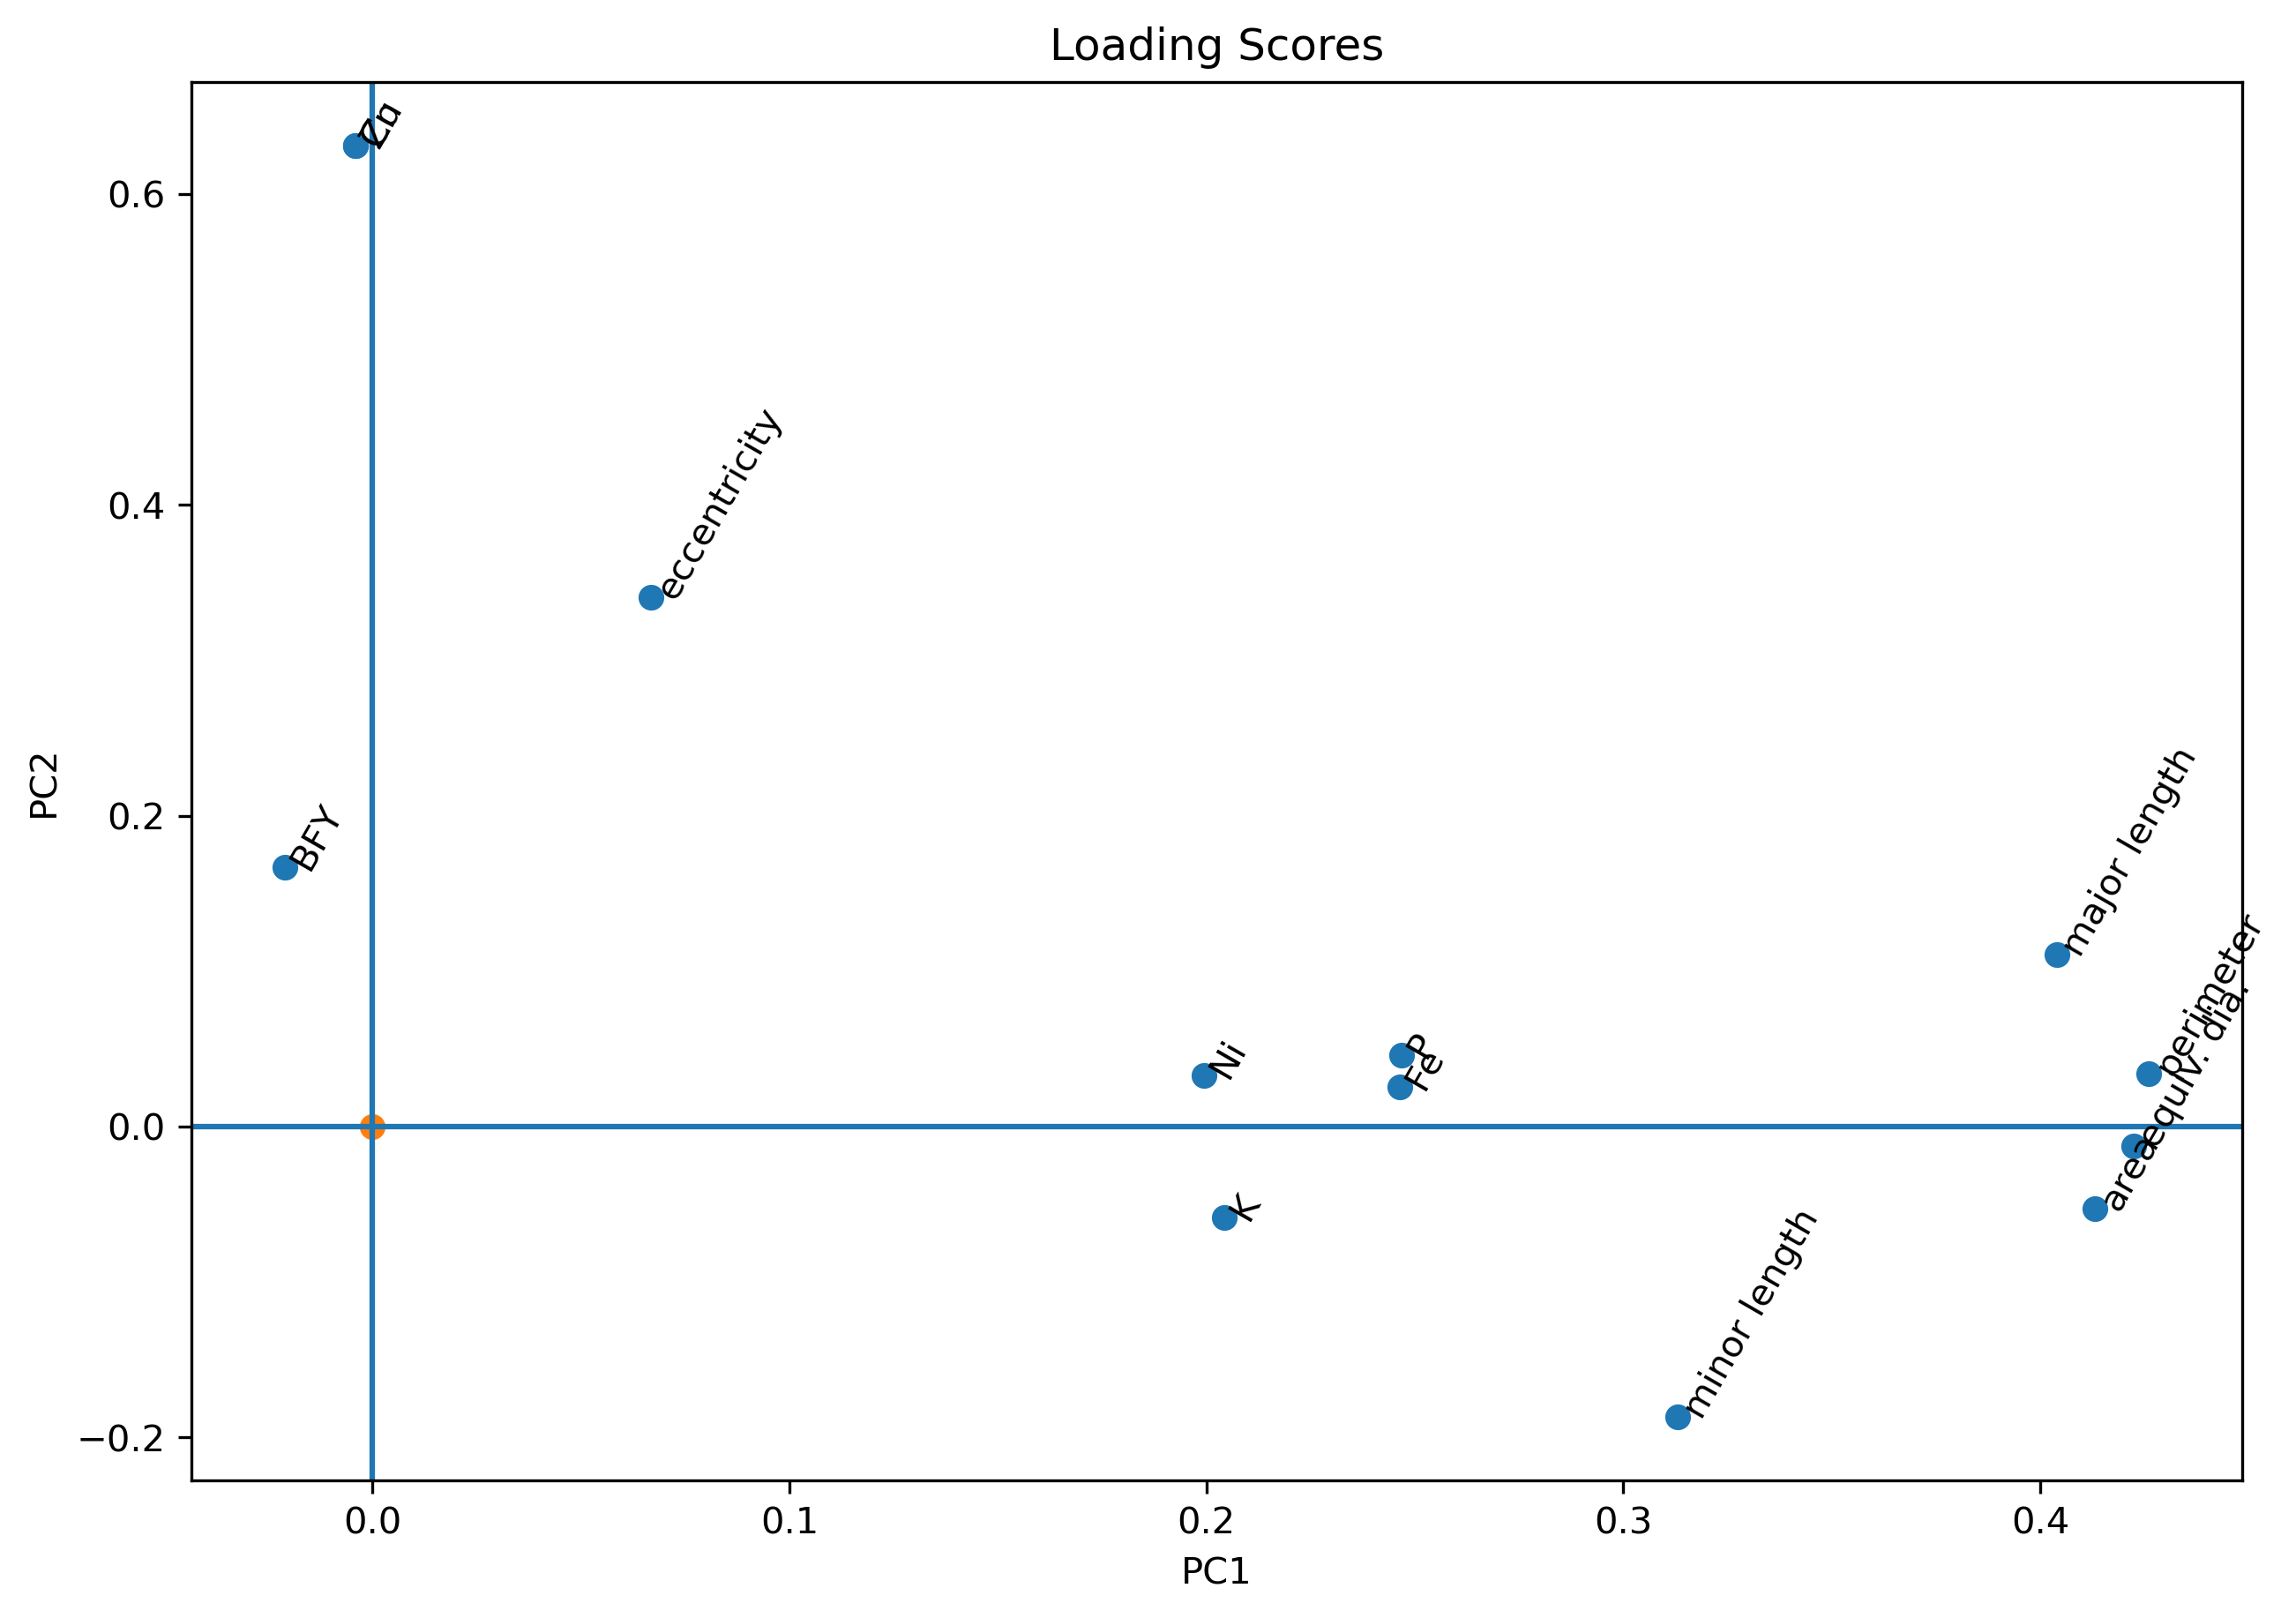

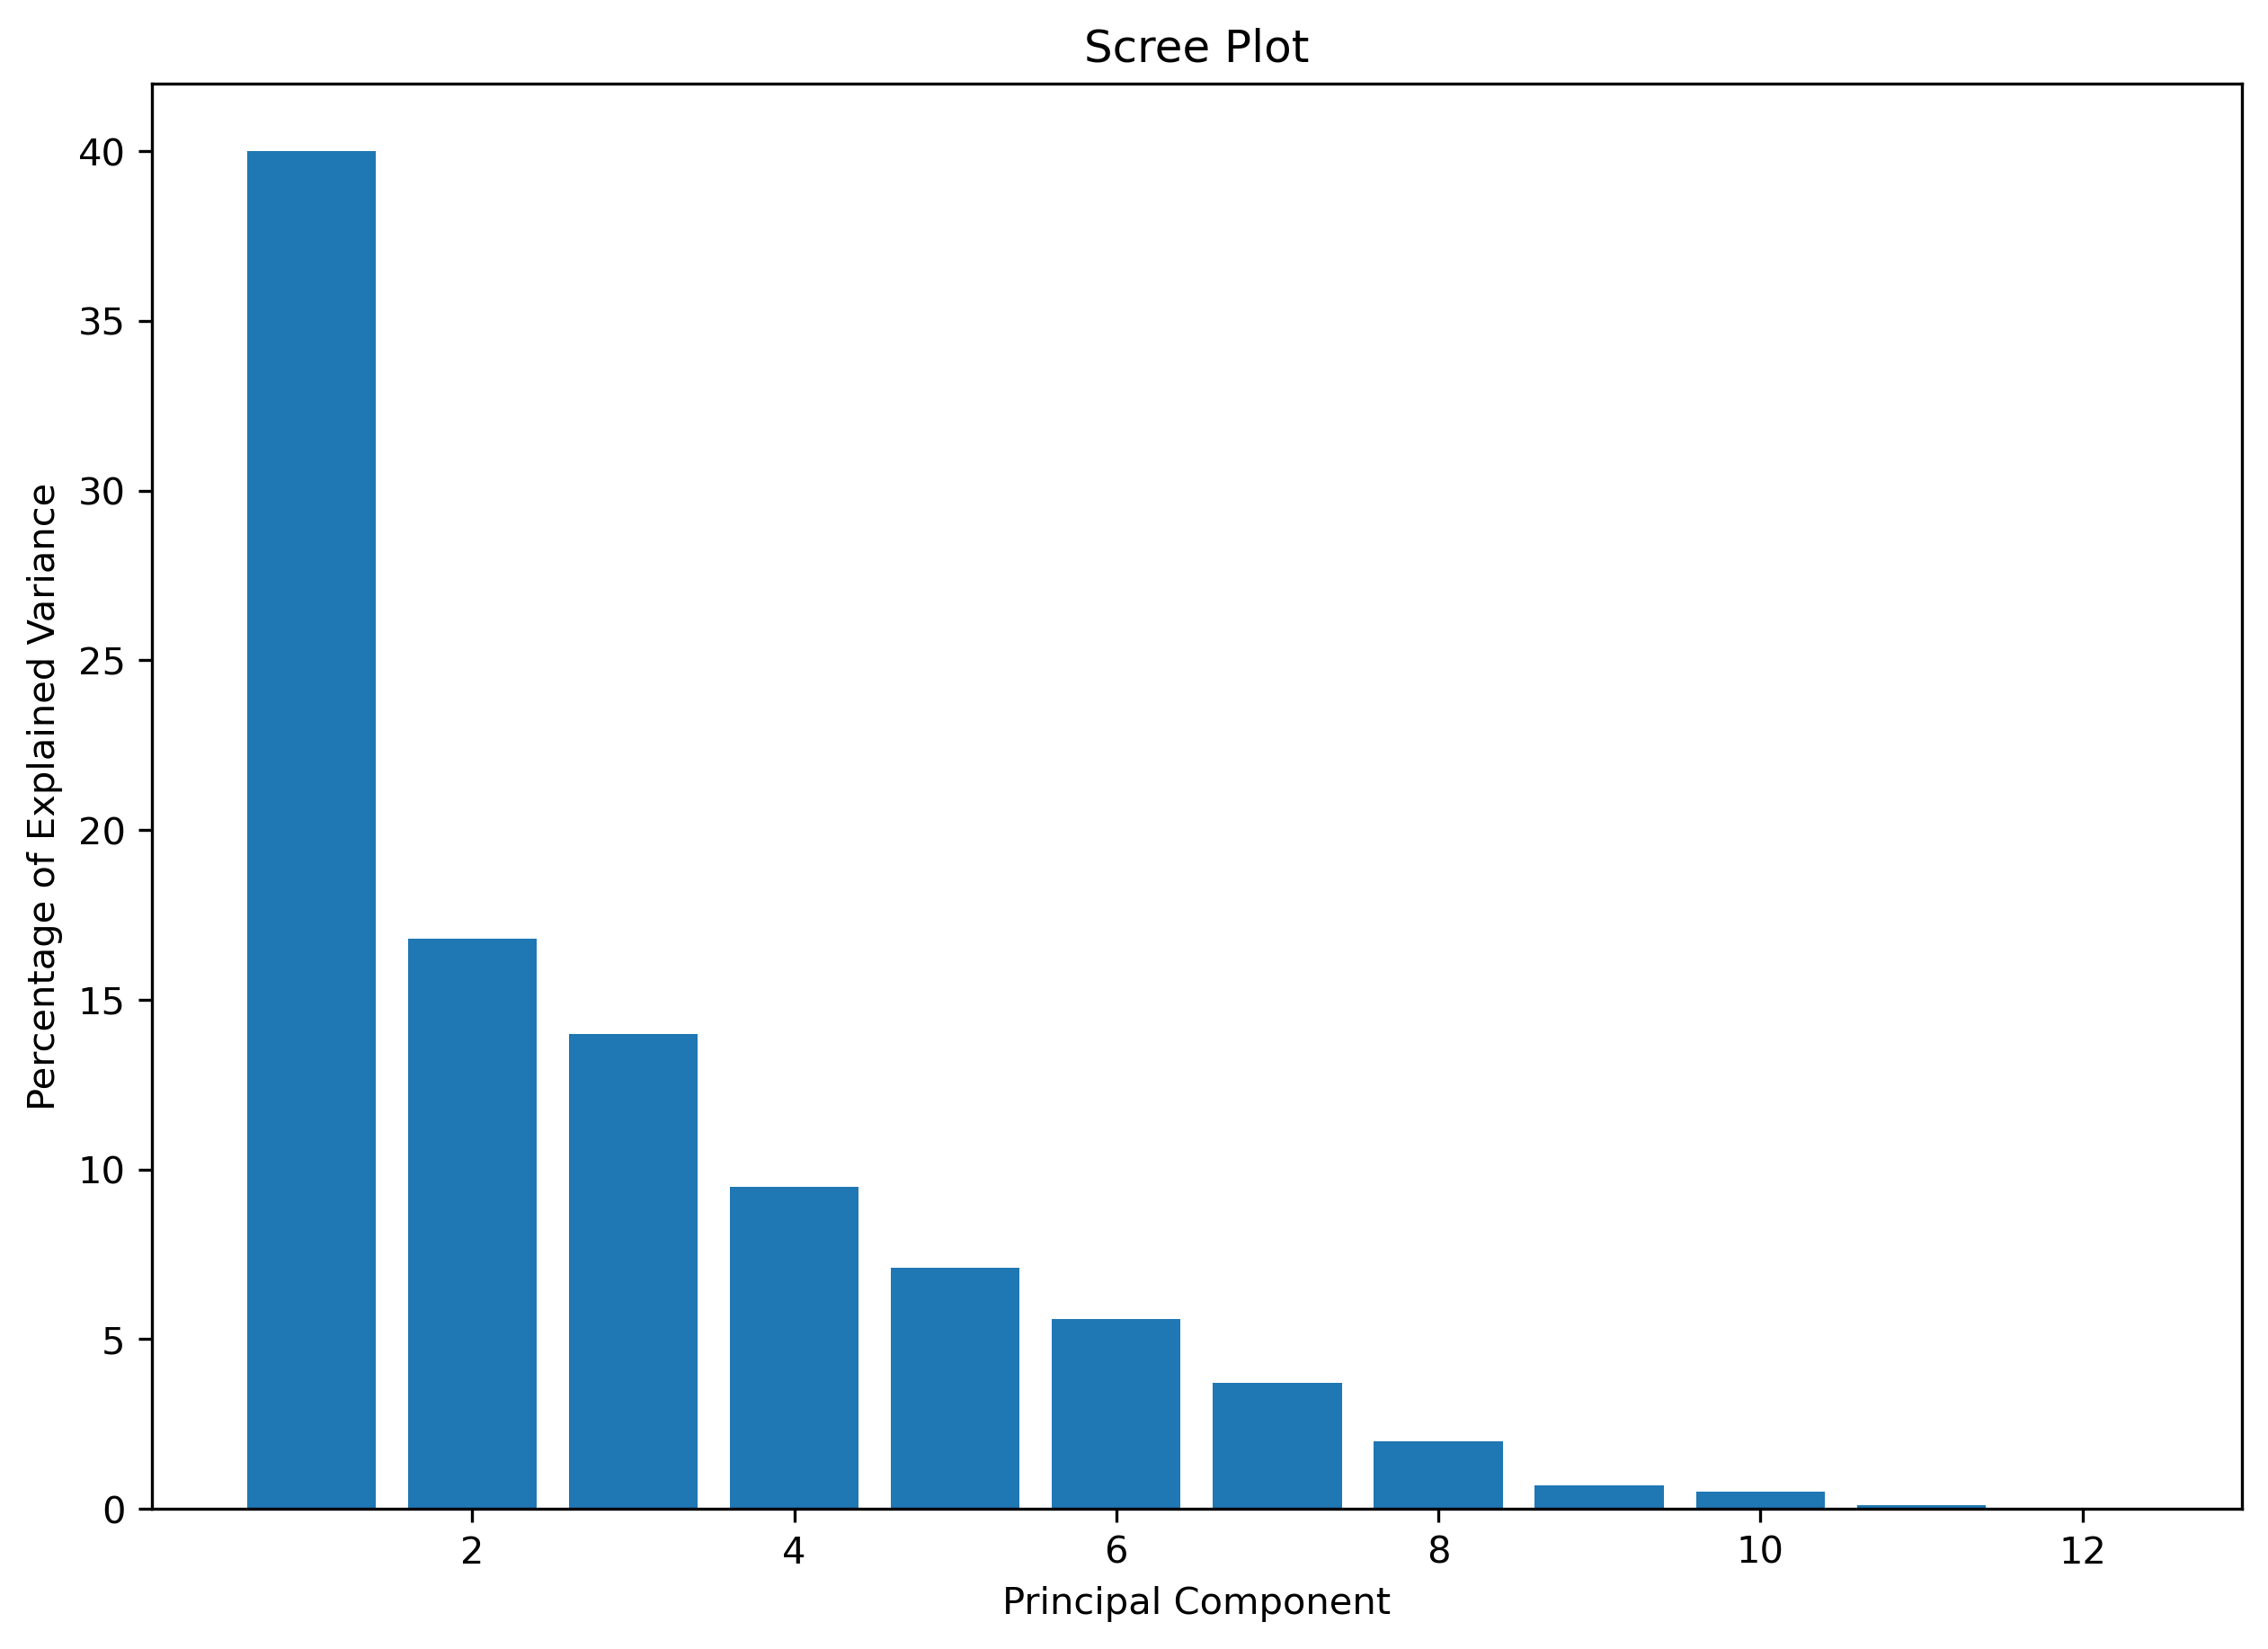

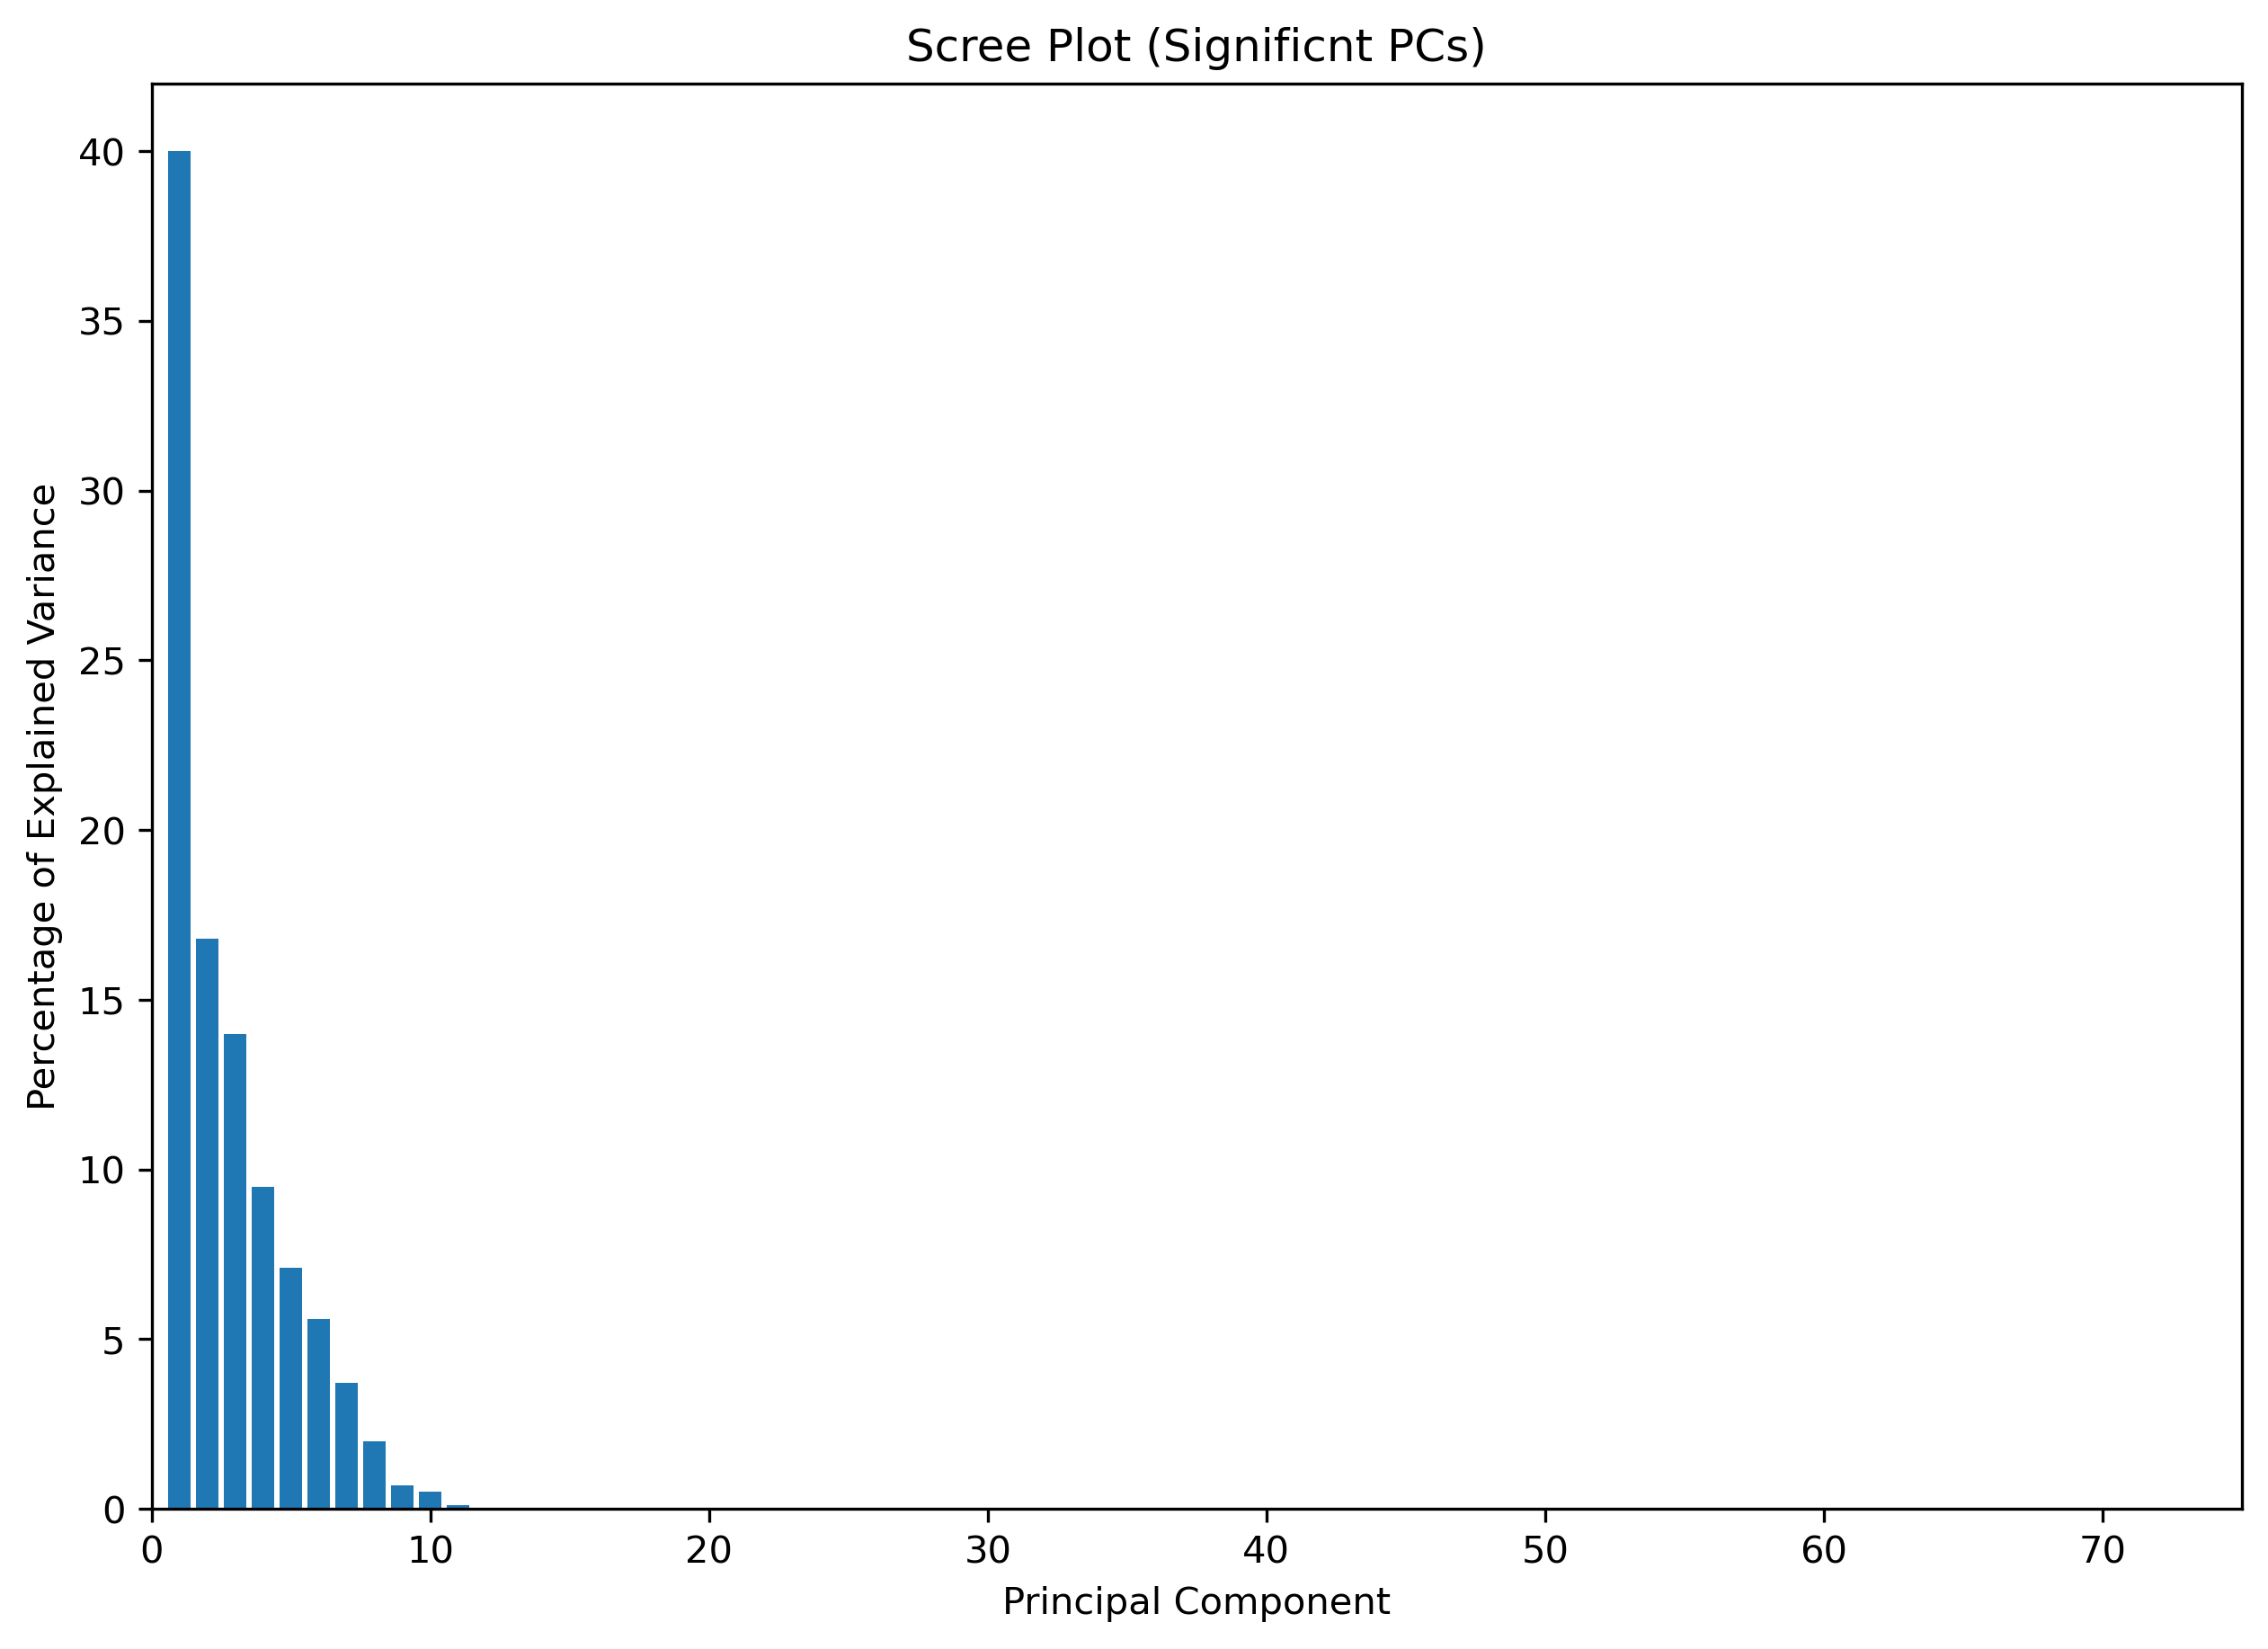

In [18]:
X_standard = StandardScaler().fit_transform(mod_X)
# print(X_standard[0])

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_standard)

secondaryDf['PC1']=principalComponents[:,0]
secondaryDf['PC2']=principalComponents[:,1]

print('Cells, PCs', principalComponents.shape)

print('singular_values_:', pca.singular_values_)
print('explained_variance:', pca.explained_variance_)
print('components:', pca.components_)

fig = plt.figure(figsize=(10,7),dpi=300);

plt.scatter(pca.components_[0],pca.components_[1]) #, tick_label=PClabels
plt.title('Loading Scores')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axhline()
plt.axvline()

names = ['area','eccentricity','equiv. dia.','major length','minor length','perimeter',
        'K','P','Ni','Zn',
         'Fe','Cu', 'BFY']

for i, txt in enumerate(names):
    plt.annotate(txt, (pca.components_[0][i], pca.components_[1][i]), rotation=60, size=10)

plt.scatter(0,0)
plt.show()

#scree plot

high_pca = PCA(n_components=12)
high_pca.fit_transform(X_standard)

#calculate percentage of variation in each principal components
per_var=np.round(high_pca.explained_variance_ratio_*100, decimals=1)
PClabels =['PC' + str(x) for x in range(1,len(per_var)+1)]

fig = plt.figure(figsize=(10,7),dpi=300);
plt.bar(x=range(1, len(per_var)+1),height=per_var) #, tick_label=PClabels
plt.title('Scree Plot')
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.show()
#zoom in on the important PCs
fig = plt.figure(figsize=(10,7),dpi=300);
plt.bar(x=range(1, len(per_var)+1),height=per_var) #, tick_label=PClabels
plt.title('Scree Plot (Significnt PCs)')
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.xlim(0,75)
plt.show()

Text(0, 0.5, 'PC2')

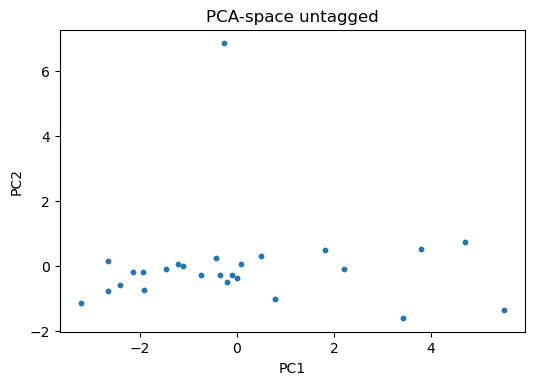

In [19]:
plt.figure(dpi=100)
plt.scatter(secondaryDf['PC1'],secondaryDf['PC2'], s=10)
plt.title('PCA-space untagged')
plt.xlabel('PC1')
plt.ylabel('PC2')

/APSshare/anaconda3/x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


inertia:  92.42197521316179


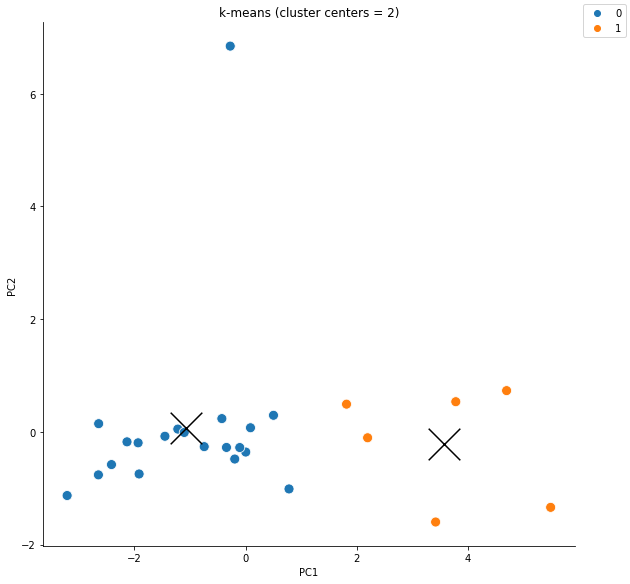

In [20]:


kmeans = KMeans(n_clusters = 2, random_state = 42).fit(secondaryDf[['PC1','PC2']].to_numpy())
inertia=kmeans.inertia_
secondaryDf['Class'] = kmeans.labels_

print('inertia: ', inertia)
pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='Class', height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()
pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
pp.set(xlabel='PC1',
       ylabel='PC2',
       title='k-means (cluster centers = 2)')

plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], marker='x',s=1000, facecolors='black')

In [21]:
# condition check

labels = [0] * mod_X.shape[0]

True_list = secondaryDf.loc[
    (secondaryDf['major_axis_length']>=1) & 
    (secondaryDf['major_axis_length']<= 3) &
    (secondaryDf['minor_axis_length']>=0.5) & 
    (secondaryDf['minor_axis_length']<= 1.5) &
    (secondaryDf['K']<=secondaryDf['K'].median())
   ].index.tolist()    
    
print('Length true list: ', len(True_list) )

for idx in True_list:
    labels[idx]=1 
    
y=labels
    
for idx in range(len(labels)):
    if labels[idx] ==0:
        labels[idx] = 'false'
    if labels[idx] ==1:
        labels[idx] = 'true'


        
        
secondaryDf['text_labels'] = labels


Length true list:  8


/APSshare/anaconda3/x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(secondaryDf)

,Pixel_count,area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,perimeter,K,P,Ni,Zn,Fe,Cu,BFY,x_res,y_res,avg_res,x_origin,y_origin,x_motor,y_motor,original index,PC1,PC2,Class,text_labels
0,31,1.986528,0.926912,1.590385,2.643454,0.992034,5.456846,0.000042,0.000084,0.000102,0.000076,0.000038,0.000076,0.007248,0.25,0.256287,0.253143,110.674377,-661.065186,175.174377,-654.401733,0,-0.427365,0.235008,0,true
1,29,1.858365,0.945945,1.538227,2.743256,0.889710,5.351990,0.000064,0.000055,0.000096,0.000046,0.000044,0.000046,0.007148,0.25,0.256287,0.253143,110.674377,-661.065186,121.174377,-651.838867,1,-0.344275,-0.276699,0,false
2,38,2.435098,0.932115,1.760813,2.920293,1.057619,6.172843,0.000050,0.000083,0.000103,0.000057,0.000046,0.000057,0.007343,0.25,0.256287,0.253143,110.674377,-661.065186,178.674377,-647.738281,3,0.501833,0.293912,0,false
3,38,2.435098,0.933353,1.760813,3.025941,1.086188,6.469419,0.000044,0.000085,0.000089,0.000042,0.000043,0.000042,0.007300,0.25,0.256287,0.253143,110.674377,-661.065186,152.424377,-647.225708,4,0.087898,0.072640,0,false
4,94,6.023664,0.989542,2.769398,7.592960,1.095271,15.050849,0.000060,0.000079,0.000101,0.000048,0.000051,0.000048,0.007345,0.25,0.256287,0.253143,110.674377,-661.065186,135.174377,-644.406555,5,4.698063,0.731400,1,false
5,31,1.986528,0.877474,1.590385,2.300224,1.103244,5.037424,0.000050,0.000077,0.000096,0.000046,0.000046,0.000046,0.007193,0.25,0.256287,0.253143,110.674377,-661.065186,142.924377,-644.150269,6,-0.195589,-0.482310,0,false
6,50,3.204077,0.971656,2.019791,4.318267,1.020839,7.604838,0.000049,0.000099,0.000133,0.000053,0.000039,0.000053,0.007266,0.25,0.256287,0.253143,110.674377,-661.065186,173.174377,-643.637695,7,1.816581,0.491167,1,false
7,22,1.409794,0.930473,1.339778,2.246039,0.822862,4.234562,0.000042,0.000054,0.000083,0.000047,0.000047,0.000047,0.007231,0.25,0.256287,0.253143,110.674377,-661.065186,113.424377,-642.868835,8,-1.452196,-0.078373,0,true
8,73,4.677952,0.986584,2.440523,6.305439,1.029406,12.099995,0.000079,0.000094,0.000095,0.000063,0.000047,0.000063,0.007273,0.25,0.256287,0.253143,110.674377,-661.065186,123.174377,-642.356262,9,3.783197,0.534949,1,false
9,14,0.897141,0.905899,1.068773,1.643562,0.696039,2.654279,0.000052,0.000060,0.000086,0.000046,0.000042,0.000046,0.007269,0.25,0.256287,0.253143,110.674377,-661.065186,111.924377,-641.331116,11,-2.134906,-0.177155,0,false


dict_keys(['true', 'false'])


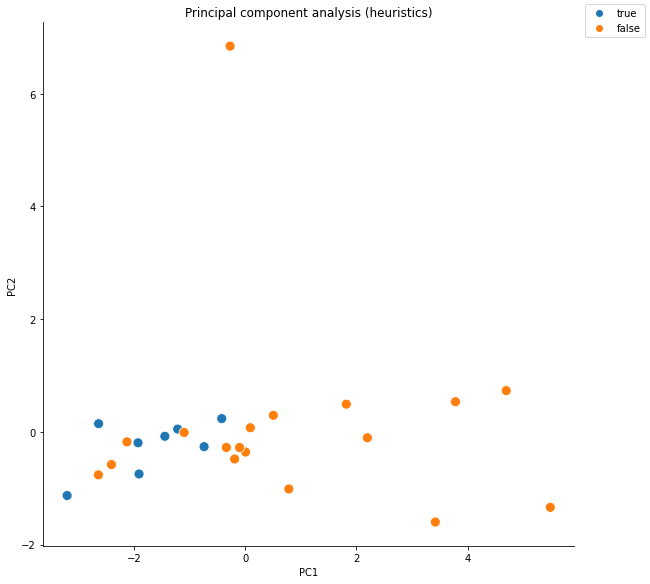

In [23]:
pp = sns.pairplot(data=secondaryDf,
                  y_vars=['PC2'],
                  x_vars=['PC1'],
                  kind = 'scatter', 
                 diag_kind='hist', corner = 'True', hue='text_labels',  height=8,plot_kws={"s": 100}
                 )
leg_handles = pp._legend_data.values()
leg_labels = pp._legend_data.keys()

pp.fig.legend(handles=leg_handles, labels=leg_labels, loc='upper right', ncol=1)
pp._legend.remove() # remove existing legend
print(leg_labels)

pp.set(xlabel='PC1',
       ylabel='PC2',
       title='Principal component analysis (heuristics)')



<IPython.core.display.Javascript object>


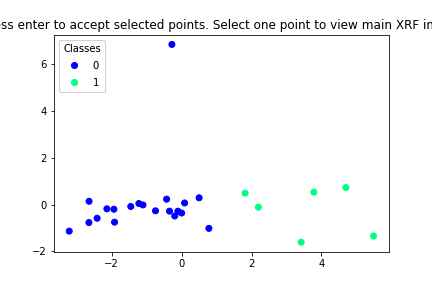

In [24]:


%matplotlib notebook



subplot_kw = dict(autoscale_on=True)
fig, ax = plt.subplots(subplot_kw=subplot_kw)

# pts = ax.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], marker='x',s=1000,c=secondaryDf.Class, facecolors='black')

pts = ax.scatter(secondaryDf['PC1'].to_numpy(),secondaryDf['PC2'].to_numpy(), c=secondaryDf.Class,
                 cmap='winter')


# produce a legend with the unique colors from the scatter
legend = ax.legend(*pts.legend_elements(),
                    loc="upper left", title="Classes")
ax.add_artist(legend)


selector = SelectFromCollection(ax, pts)



fig.canvas.mpl_connect("key_press_event", accept)
ax.set_title("Press enter to accept selected points. Select one point to view main XRF image")

plt.show()



In [25]:
#shows selected indices in secondaryDf

print('number of selected cells:', len(selector.ind))

print('modified_indices:', selector.ind)

#conversions to original indices
target_scan_cell_indices = secondaryDf['original index'][selector.ind].to_numpy()
print('original indices:', target_scan_cell_indices)
print('K-means classes \n')
secondaryDf['Class'][selector.ind]

print('cell centers (pixel value in XRF image):' , X_centers[target_scan_cell_indices])
print('\n')
print('cell centers in x (pixel value in XRF image):' , X_centers[target_scan_cell_indices][0])
print('\n')
print('cell x_origins (motor coordinates):' , X_x_origin[target_scan_cell_indices])
print('\n')
print('cell y_origins (motor coordinates):' , X_y_origin[target_scan_cell_indices])

print('\n')
print('send to motor')
print('cell x_center (motor coordinates):' , X_x_motor[target_scan_cell_indices])
print('\n')
print('cell y_center (motor coordinates):' , X_y_motor[target_scan_cell_indices])
print('\n')

print('BBox motor width (x): ', BASE_PATCH_WIDTH*X_x_res[target_scan_cell_indices])
print('BBox motor width (y): ', BASE_PATCH_WIDTH*X_y_res[target_scan_cell_indices])


print('Main XRF image file (selected):' , X_xrf_track_files[target_scan_cell_indices])

motor_coordinates = np.vstack((X_x_motor[target_scan_cell_indices],X_y_motor[target_scan_cell_indices])).T
print(motor_coordinates)


number of selected cells: 0
modified_indices: []
original indices: []
K-means classes 

cell centers (pixel value in XRF image): []




IndexError: index 0 is out of bounds for axis 0 with size 0